# Week 8 - Multivariate Analysis

## Please run the cells of the notebook as you get to them while reading

In [70]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from sklearn import decomposition
from sklearn import linear_model
from sklearn import metrics

# 1. Lesson: Multivariate graphs

In this lesson, we'll consider some multivariate plots: heatmaps and bubble plots.  We'll also consider principal component analysis and multiple regression.

### Heatmaps

In this plot, we use a heatmap to count the total traffic tickets given to citizens.  A heatmap requires the x and y axes to be categorical, while the color involves a third, numerical variable.  In this example, each row of the DataFrame represents a traffic ticket given to one person in a particular city and year.  The data are given as three columns (city, year, and ticket), so we must use a pivot_table to transform it into a two-dimensional grid.  The cmap is set to "Blues" in the first example, meaning that the heatmap uses only blue as its color.  However, we could also use a multicolor map like "viridis" in the second example.  I personally think "Blues" is easier to read - what do you think?  Here is a reference guide to the color maps:

https://matplotlib.org/stable/gallery/color/colormap_reference.html

In [71]:
np.random.seed(0)
num_samples = 100
city_series = np.random.choice(["New York", "Boston", "Atlanta", "Washington, D. C."], size = num_samples)
year_series = np.random.choice([2018, 2019, 2020], size = num_samples)
ticket_series = np.random.randint(50, 150, size = num_samples) # Traffic tickets can be from $50 to $150
df = pd.DataFrame({"city": city_series, "year": year_series, "ticket": ticket_series})
pivot = df.pivot_table(index = ["city"], columns = ["year"], values = "ticket", aggfunc = "sum")

In [72]:
df.iloc[0:5] # first five rows of a long DataFrame

,city,year,ticket
0,New York,2019,79
1,"Washington, D. C.",2020,71
2,Boston,2018,75
3,New York,2018,130
4,"Washington, D. C.",2020,110


In [73]:
pivot # 2 by 2 grid showing total ticket amounts

year,2018,2019,2020
city,,,
Atlanta,742,440,538
Boston,775,628,922
New York,1122,841,596
"Washington, D. C.",1258,451,1385


Text(0.5, 1.0, 'Total traffic tickets by city and year')

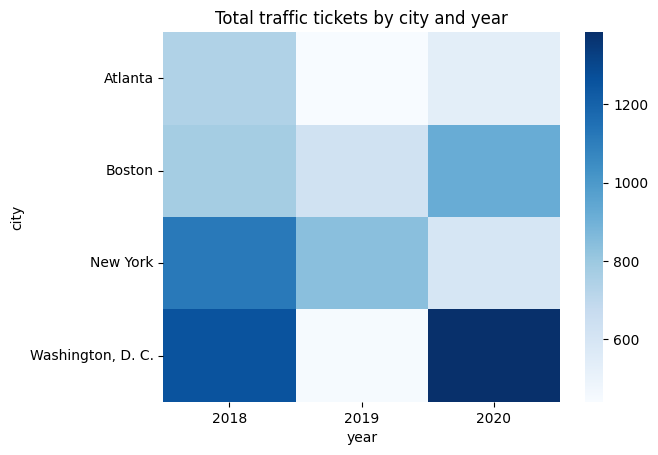

In [74]:
ax = sns.heatmap(pivot, cmap = "Blues")
ax.set_title("Total traffic tickets by city and year")

Text(0.5, 1.0, 'Average traffic ticket value by city and year')

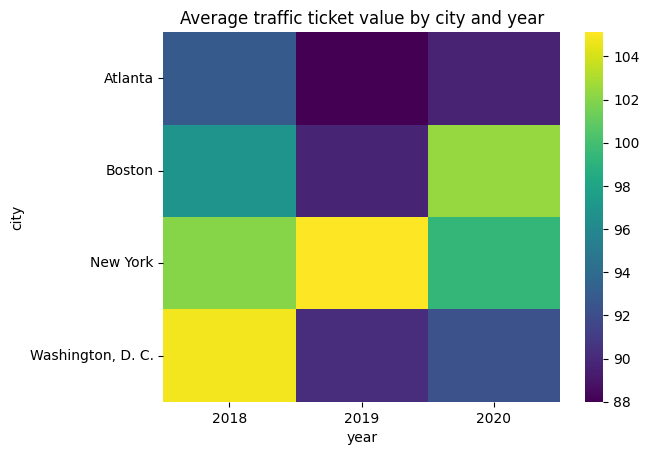

In [75]:
pivot2 = df.pivot_table(index = ["city"], columns = ["year"], values = "ticket", aggfunc = "mean") # note mean, not sum this time
ax2 = sns.heatmap(pivot2, cmap = "viridis") # do you think this is a better or worse scale than Blues?
ax2.set_title("Average traffic ticket value by city and year")

### Bubble plots

A bubble plot is just a scatter plot, but with the dot size representing a third variable.  Here, each data point shows a tree (I mean the kind of tree that is a plant and grows in the ground, not a decision tree), with its height, width of branches, and root depth.  The bubble size in the bubble plot represents the root depth, while the other variables are shown on the x and y axes.  From this plot, we can see that the root depth is strongly correlated with both the width of branches and the tree height.

Text(0, 0.5, 'width of branches')

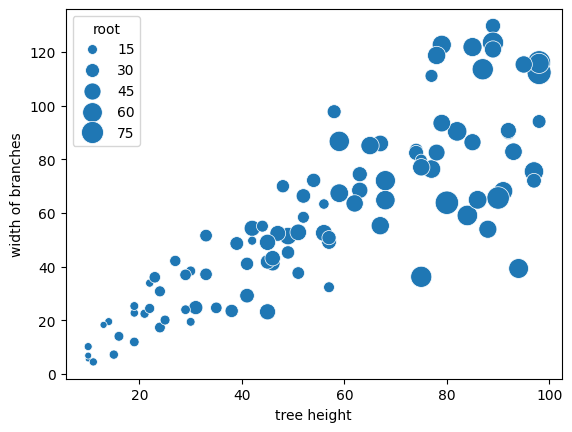

In [76]:
np.random.seed(0)
num_samples = 100
height_series = np.random.randint(10, 100, size = num_samples) # tree height
width_series = height_series * np.maximum(np.random.normal(scale = 0.3, loc = 1, size = num_samples), 0.25) # strongly related to height
root_series = height_series * np.maximum(np.random.normal(scale = 0.2, loc = 0.7, size = num_samples), 0.3) # strongly related to height
df2 = pd.DataFrame({'height': height_series, 'width': width_series, 'root': root_series})
minroot = root_series.min()
maxroot = root_series.max()
maxbubble = 300
ax = sns.scatterplot(data = df2, x = "height", y = "width", size = "root", sizes = (minroot / maxroot * maxbubble, maxbubble))
ax.set_xlabel("tree height")
ax.set_ylabel("width of branches")

### Principal Component Analysis

Principal Component Analysis can be thought of as a way to use one (or a few) linear combinations of the coordinates in order to explain all of the coordinates.  It is most useful when there are strong correlations between some or all of the coordinates.  Principal Component Analysis can show us which linear combinations are most (and least) useful for explaining the data.

With the trees data, the three values (height, width, and root) are highly correlated.  For this reason, Principal Component Analysis shows that most of the variance can be explained by a single value which is a linear combination of height, width, and root.  What this means is that if the first components_ vector in the code below (the "first principal component") is \[a, b, c\], for some specific numbers a, b, and c, then the value v = a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r), where the mu's are the means, is highly informative about the values of height, width, and root.  In this case, because height, width, and root are so highly correlated, we can almost assume that all of the data is located along an axis defined by the vector \[a, b, c\].  The point v * \[a, b, c\] + (mean vector) = (a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r)) * \[a, b, c\] + (mean vector) is therefore approximately equal to the data point (height, width, root) in question.  The mean vector is \[mu_h, mu_w, mu_r\].  Importantly, there is still variance unexplained by this one value - just knowing v * \[a, b, c\] does not tell you the height, width, and root with 100% accuracy.  If the second principal component is \[d, e, f\], then we could approximate the tree vector even more accurately as: (height, width, root) = (a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r)) * \[a, b, c\] + (d * (height - mu_h) + e * (width - mu_w) + f * (root - mu_r)) * \[d, e, f\] + (mean vector).

The printing of "components_", below, shows the first principal component \[a, b, c\].  If you draw a vector in the direction shown, you will be heading in the direction where the values height, width, and root change most rapidly.  A later computation shows all three principal component vectors.

**Optional exercise for the reader:** show that if all three principal components are included, then equality is exact.  This is going to be true simply because the principal components are orthonormal: the projections onto a complete set of orthonormal vectors always add up to the original vector.

(height, width, root) = (a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r)) * \[a, b, c\] + (d * (height - mu_h) + e * (width - mu_w) + f * (root - mu_r)) * \[d, e, f\] + (g * (height - mu_h) + h * (width - mu_w) + i * (root - mu_r)) * \[g, h, i\] + \[mu_h, mu_w, mu_r\].

For this proof, we must use the fact that the principal component vectors are orthonormal.  That is, any pair of them are orthogonal, even with a transpose (ad + be + cf = 0, ag + bh + ci = 0, dg + eh + fi = 0, ab + de + gh = 0, ac + df + gi = 0, bc + ef + hi = 0) and any one of them is a unit vector, even with a transpose (a^2 + b^c + c^2 = 1, d^2 + e^2 + f^2 = 1, g^2 + h^2 + i^2 = 1, a^2 + d^2 + g^2 = 1, b^2 + e^2 + h^2 = 1, c^2 + f^2 + i^2 = 1).  If you write out the equation above as a single vector, then apply the orthonormality rules, you should be able to prove equality.

In [77]:
pca = decomposition.PCA(n_components = 1)
pca.fit(df2)
print(f"The first principal component explains {pca.explained_variance_ratio_[0]} of the variance")
print(f"The components_ vector is [a, b, c] = {pca.components_}")
mu_h, mu_w, mu_r = df2.mean().values
print(f"(height, width, root) is approximately equal to ({pca.components_[0][0]:.2} * (height - {mu_h:.2}) + {pca.components_[0][1]:.2} * (width - {mu_w:.2}) + {pca.components_[0][2]:.2} * (root - {mu_r:.2})) * ({pca.components_[0][0]:.2}, {pca.components_[0][1]:.2}, {pca.components_[0][2]:.2}) + ({mu_h:.2}, {mu_w:.2}, {mu_r:.2})")
print("Examples: (estimating the the vector equals its projection onto the first principal component)")
df_example = df2.copy()
df_example["v"] = pca.components_[0][0] * (df2["height"] - mu_h) + pca.components_[0][1] * (df2["width"] - mu_w) + pca.components_[0][2] * (df2["root"] - mu_r)
df_example["height_est"] = df_example["v"] * pca.components_[0][0] + mu_h
df_example["width_est"] = df_example["v"] * pca.components_[0][1] + mu_w
df_example["root_est"] = df_example["v"] * pca.components_[0][2] + mu_r
print(df_example.iloc[0:5])
print("Means:")
print(f"mu_h = {mu_h:.3}", f"mu_w = {mu_w:.3}", f"mu_r = {mu_r:.3}")

The first principal component explains 0.8686108480944689 of the variance
The components_ vector is [a, b, c] = [[0.59031629 0.71908728 0.36666083]]
(height, width, root) is approximately equal to (0.59 * (height - 5.6e+01) + 0.72 * (width - 5.9e+01) + 0.37 * (root - 3.6e+01)) * (0.59, 0.72, 0.37) + (5.6e+01, 5.9e+01, 3.6e+01)
Examples: (estimating the the vector equals its projection onto the first principal component)
   height       width       root          v  height_est  width_est   root_est
0      54   72.139334  31.517932   6.287751   60.001762  63.563941  38.673095
1      57   49.169527  33.768693  -7.633330   51.783921  53.553468  33.568780
2      74   83.443733  28.770850  25.215680   71.175227  77.174773  45.613225
3      77   76.353866  53.061241  30.794730   74.468631  81.186597  47.658844
4      77  111.095365  26.006307  45.856916   83.360084  92.017624  53.181557
Means:
mu_h = 56.3 mu_w = 59.0 mu_r = 36.4


If we were to choose a second or third component to preserve, that values below show that each would explain a small, additional amount of the variance.  This means that with this particular dataset, we should likely do PCA using only one component and not two.  If the components' explained variances were closer in magnitude to each other, we might have to include two or even all three values to explain the data.

In [78]:
pca3 = decomposition.PCA(n_components = 3)
pca3.fit(df2)
print(pca3.explained_variance_ratio_)
print(pca3.components_)

[0.86861085 0.09414617 0.03724298]
[[ 0.59031629  0.71908728  0.36666083]
 [ 0.32633701 -0.62809127  0.70640322]
 [ 0.73826204 -0.29734633 -0.6054373 ]]


The principal component vectors shown are orthogonal to each other (their dot product is basically zero).  Here, we check that using the first two vectors.

In [79]:
print(np.array(pca3.components_[0]).dot(np.array(pca3.components_[1])))

-1.6653345369377348e-16


We can use the projection onto the first principal component as if it were a new feature.  For instance, we could plot a histogram of the data against the magnitude of the projection onto the first principal component.  In fact, for some purposes, this magnitude (which we have called v) might make a better feature for data analysis than either height, width, or root.  We must subtract off the mean before the dot product; the understanding is that this represents the component of the data relative to the mean.

<Axes: >

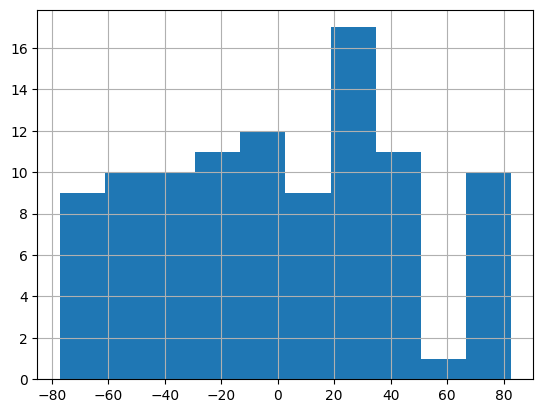

In [80]:
((df2 - df2.mean()).dot(np.array(pca.components_[0]))).hist()

In [81]:
# Showing that this is the same as the value we've called "v"
(df_example["v"] - (df2 - df2.mean()).dot(np.array(pca.components_[0]))).max()

np.float64(0.0)

### Linear Regression

Now let's run a linear regression model to predict the root from the height and width, as well as predicting the third principal component from the first and second.  Which is easier to predict?

### Predicting the root from the height and width

In [82]:
linreg = linear_model.LinearRegression()
linreg.fit(df2[['height', 'width']], df2['root'])
preds = linreg.predict(df2[['height', 'width']])
metrics.mean_squared_error(preds, df2['root']) # Mean squared error as a metric

138.22487356329611

In [83]:
np.corrcoef(preds, df2['root']) # Correlation coefficient as a metric

array([[1.        , 0.79468295],
       [0.79468295, 1.        ]])

### Predicting the third principal component from the first and second

In [84]:
first_principal_component_score = (df2 - df2.mean()).dot(np.array(pca3.components_[0]))
second_principal_component_score = (df2 - df2.mean()).dot(np.array(pca3.components_[1]))
third_principal_component_score = (df2 - df2.mean()).dot(np.array(pca3.components_[2]))

In [85]:
linreg_first = linear_model.LinearRegression()
pc_X = np.array([first_principal_component_score, second_principal_component_score]).T
linreg_first.fit(pc_X, third_principal_component_score)
preds = linreg_first.predict(pc_X)
metrics.mean_squared_error(preds, third_principal_component_score) # The mean squared error is a bit smaller here.

78.74928905273173

In [86]:
np.corrcoef(preds, third_principal_component_score) # More importantly, the correlation is basically zero

array([[1.00000000e+00, 1.55495941e-14],
       [1.55495941e-14, 1.00000000e+00]])

Here, we see that the projections of the first two principal components have no ability to predict the projection of the third, when measured by correlation.  This is a special property of principal components.  It is intended to ensure that the each component gives new information not present in the previous components.

The mean_squared_error is misleading - it makes it look like the error is less for the second computation than the first; but the correlation coefficient is giving more useful information here.  We cannot compare the mean squared error for two totally different computations, because mean squared error is highly dependent on the magnitudes of the values in question!

# 2. Weekly graph question

The tree data above can be graphed via either a pairplot or a bubble plot.  What are the advantages and disadvantages of each?

Text(0, 0.5, 'width of branches')

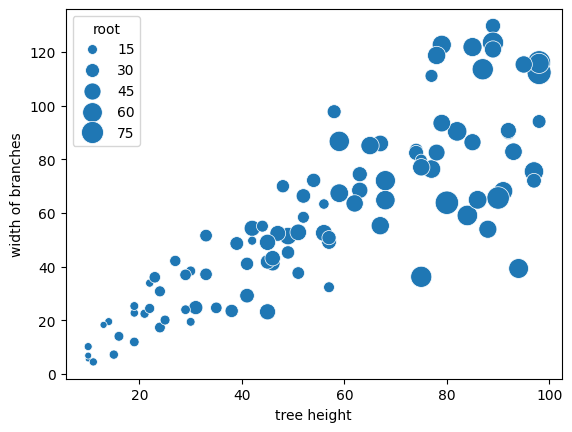

In [87]:
ax = sns.scatterplot(data = df2, x = "height", y = "width", size = "root", sizes = (minroot / maxroot * maxbubble, maxbubble))
ax.set_xlabel("tree height")
ax.set_ylabel("width of branches")

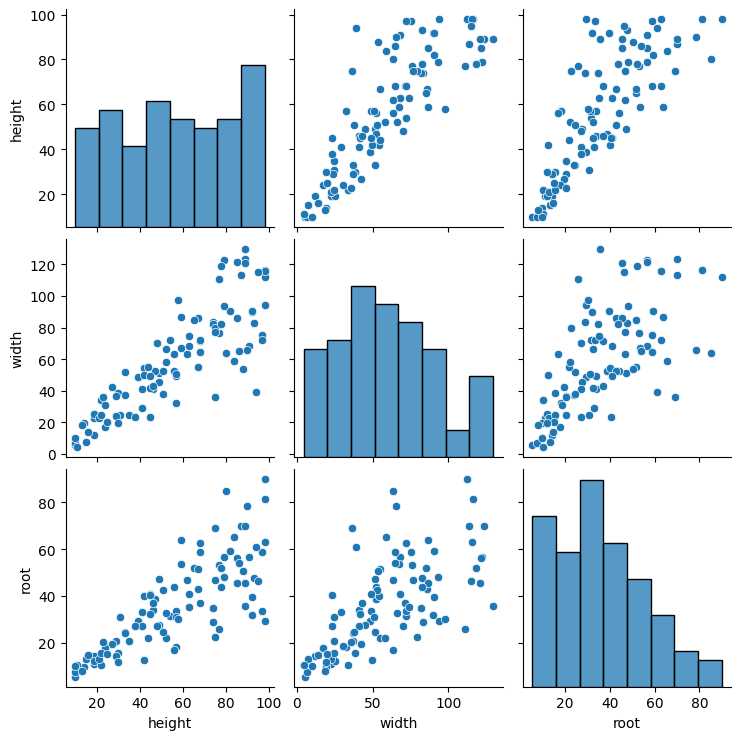

In [88]:
sns.pairplot(df2)

Bubble Plot:
It is space efficient because it can show all 3 things in one graph. This makes it easy to read and understand. It is easy to compare one data point to another. The disadantage is that sometimes it is hard to differentiate between the sizes of the bubbles.

Pairplot:
It is easy to read with exact data points. It does not overlap different relationships making it easier to compare the data. Its disadvantage is that it is a lot of information spread out a large space, making it harder to read and is not easily understood.

# 3. Homework - Grocery Store Correlation

In a particular state, the price of milk is highly correlated with the price of cheese.  Neither is correlated with the price of bread.

In [89]:
num_points = 1000
np.random.seed(0)
milk_series = np.maximum(np.random.normal(scale = 0.5, loc = 2.00, size = num_points), 1)
cheese_series = milk_series * np.maximum(np.random.normal(scale = 0.1, loc = 1.00, size = num_points), 0.5)
bread_series = np.maximum(np.random.normal(scale = 1.0, loc = 3.00, size = num_points), 1)
df3 = pd.DataFrame({"milk": milk_series, "cheese": cheese_series, "bread": bread_series})


### Heatmap

Draw a heatmap where the x-axis category is a discretized version of the milk price and the y-axis category is a discretized version of the cheese price.  That is, you can choose "low", "medium", and "high" for the milk price, or, if you prefer, you can choose 1, 2, 3, 4, and 5 for the five quintiles.  (The first quintile should include the bottom fifth of the data, the second quintile contains the next fifth, and so on).

Try Googling "how do I change numerical to categorical data" to get advice on this.

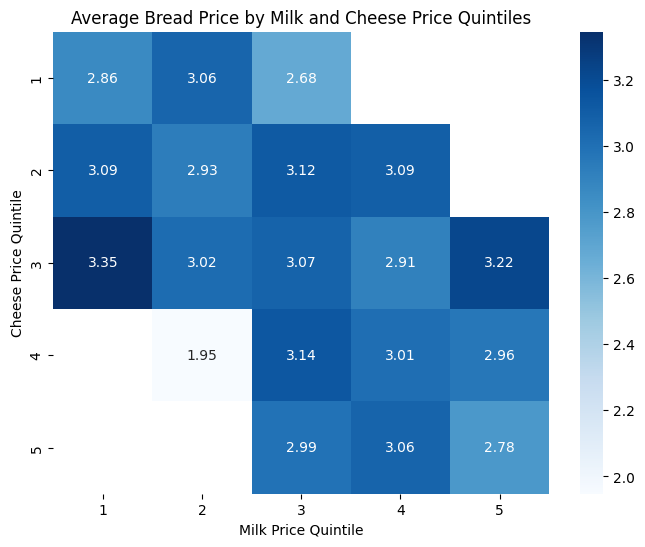

In [90]:
# Create discretized versions of milk and cheese prices using quintiles
df3_copy = df3.copy()

# Create quintiles for milk price (1-5 categories)
df3_copy['milk_quintile'] = pd.qcut(df3_copy['milk'], q=5, labels=['1', '2', '3', '4', '5'])

# Create quintiles for cheese price (1-5 categories)  
df3_copy['cheese_quintile'] = pd.qcut(df3_copy['cheese'], q=5, labels=['1', '2', '3', '4', '5'])

# Create pivot table for heatmap - using bread price as the value to aggregate
pivot_grocery = df3_copy.pivot_table(index='cheese_quintile', columns='milk_quintile', 
                                    values='bread', aggfunc='mean', observed=False)

# Create heatmap
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
ax = sns.heatmap(pivot_grocery, cmap='Blues', annot=True, fmt='.2f')
ax.set_title('Average Bread Price by Milk and Cheese Price Quintiles')
ax.set_xlabel('Milk Price Quintile')
ax.set_ylabel('Cheese Price Quintile')
plt.show()


### Bubble plot

Try all three possible bubble plots: one where the size of the dot is determined by the milk price, one where it's the cheese price, and one where it's the bread price.  Which of these plots is / are the most informative and useful?

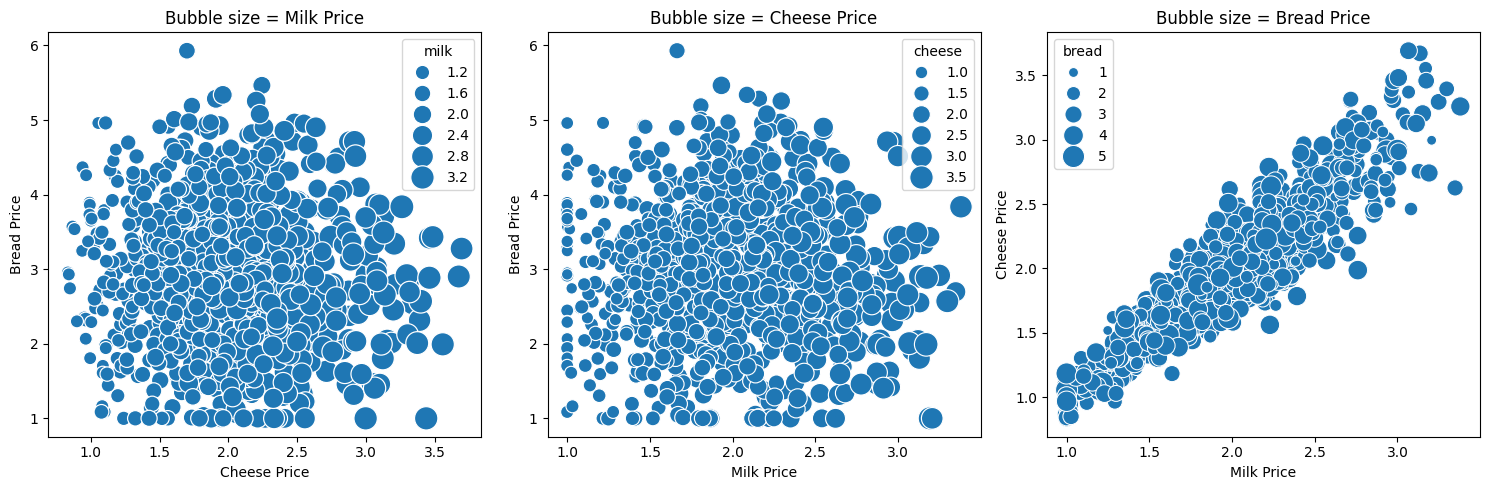

In [91]:
# Bubble plot 1: Bubble size determined by milk price
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
minmilk = df3['milk'].min()
maxmilk = df3['milk'].max()
maxbubble = 300
ax1 = sns.scatterplot(data=df3, x="cheese", y="bread", size="milk", 
                     sizes=(minmilk / maxmilk * maxbubble, maxbubble))
ax1.set_title("Bubble size = Milk Price")
ax1.set_xlabel("Cheese Price")
ax1.set_ylabel("Bread Price")

# Bubble plot 2: Bubble size determined by cheese price
plt.subplot(1, 3, 2)
mincheese = df3['cheese'].min()
maxcheese = df3['cheese'].max()
ax2 = sns.scatterplot(data=df3, x="milk", y="bread", size="cheese", 
                     sizes=(mincheese / maxcheese * maxbubble, maxbubble))
ax2.set_title("Bubble size = Cheese Price")
ax2.set_xlabel("Milk Price")
ax2.set_ylabel("Bread Price")

# Bubble plot 3: Bubble size determined by bread price
plt.subplot(1, 3, 3)
minbread = df3['bread'].min()
maxbread = df3['bread'].max()
ax3 = sns.scatterplot(data=df3, x="milk", y="cheese", size="bread", 
                     sizes=(minbread / maxbread * maxbubble, maxbubble))
ax3.set_title("Bubble size = Bread Price")
ax3.set_xlabel("Milk Price")
ax3.set_ylabel("Cheese Price")

plt.tight_layout()
plt.show()


Plot 3 is the most informative plot because it shows that bread price is independent of milk and cheese price.

### Principal component analysis

Perform a principal component analysis of the data.  What are the first, second, and third component vectors?

Challenge question: explain why the three vectors point as they do.  (Could someone have guessed the order of the three vectors, even before running the analysis?)

In [92]:
# Perform PCA on all three dimensions
pca_grocery = decomposition.PCA(n_components=3)
pca_grocery.fit(df3)

print("Explained variance ratio for each component:")
print(f"First component: {pca_grocery.explained_variance_ratio_[0]:.4f}")
print(f"Second component: {pca_grocery.explained_variance_ratio_[1]:.4f}")
print(f"Third component: {pca_grocery.explained_variance_ratio_[2]:.4f}")

print("\nPrincipal component vectors:")
print(f"First component:  [{pca_grocery.components_[0][0]:.3f}, {pca_grocery.components_[0][1]:.3f}, {pca_grocery.components_[0][2]:.3f}]")
print(f"Second component: [{pca_grocery.components_[1][0]:.3f}, {pca_grocery.components_[1][1]:.3f}, {pca_grocery.components_[1][2]:.3f}]")
print(f"Third component:  [{pca_grocery.components_[2][0]:.3f}, {pca_grocery.components_[2][1]:.3f}, {pca_grocery.components_[2][2]:.3f}]")


Explained variance ratio for each component:
First component: 0.6375
Second component: 0.3486
Third component: 0.0139

Principal component vectors:
First component:  [-0.038, -0.038, 0.999]
Second component: [0.679, 0.732, 0.054]
Third component:  [0.733, -0.680, 0.002]


Someone could not have predicted the outcome before running the analysis because it is an unexpected result. We would think that the milk and cheese correlation would be the first component but it is actually the bread component. This is because bread's high variance makes it the primary source of variation.

### Linear regression

Use linear regression to predict the milk price from the other two, the cheese price from the other two, and the bread price from the other two.  Which prediction(s) work the best, and why?

In [93]:
# Predict milk price from cheese and bread
linreg_milk = linear_model.LinearRegression()
linreg_milk.fit(df3[['cheese', 'bread']], df3['milk'])
milk_preds = linreg_milk.predict(df3[['cheese', 'bread']])
milk_mse = metrics.mean_squared_error(milk_preds, df3['milk'])
milk_corr = np.corrcoef(milk_preds, df3['milk'])[0, 1]

print("Predicting milk price from cheese and bread:")
print(f"Mean Squared Error: {milk_mse:.4f}")
print(f"Correlation coefficient: {milk_corr:.4f}")

# Predict cheese price from milk and bread
linreg_cheese = linear_model.LinearRegression()
linreg_cheese.fit(df3[['milk', 'bread']], df3['cheese'])
cheese_preds = linreg_cheese.predict(df3[['milk', 'bread']])
cheese_mse = metrics.mean_squared_error(cheese_preds, df3['cheese'])
cheese_corr = np.corrcoef(cheese_preds, df3['cheese'])[0, 1]

print("\nPredicting cheese price from milk and bread:")
print(f"Mean Squared Error: {cheese_mse:.4f}")
print(f"Correlation coefficient: {cheese_corr:.4f}")

# Predict bread price from milk and cheese
linreg_bread = linear_model.LinearRegression()
linreg_bread.fit(df3[['milk', 'cheese']], df3['bread'])
bread_preds = linreg_bread.predict(df3[['milk', 'cheese']])
bread_mse = metrics.mean_squared_error(bread_preds, df3['bread'])

bread_corr = np.corrcoef(bread_preds, df3['bread'])[0, 1]
print("\nPredicting bread price from milk and cheese:")
print(f"Mean Squared Error: {bread_mse:.4f}")
print(f"Correlation coefficient: {bread_corr:.4f}")


Predicting milk price from cheese and bread:
Mean Squared Error: 0.0345
Correlation coefficient: 0.9231

Predicting cheese price from milk and bread:
Mean Squared Error: 0.0397
Correlation coefficient: 0.9231

Predicting bread price from milk and cheese:
Mean Squared Error: 0.8773
Correlation coefficient: 0.0360


The milk and cheese prediction works better because of how highly correlated they are. Since bread is independent from milk and cheese, it is almost impossible to predict its price.

# 4. Storytelling With Data plot



Reproduce any graph of your choice in p. 120-135 of the Storytelling With Data book as best you can.  ("Use color consistently" in chapter four up to "Create a clear visual hierarchy of information" in chapter five.)    You do not have to get the exact data values right, just the overall look and feel.

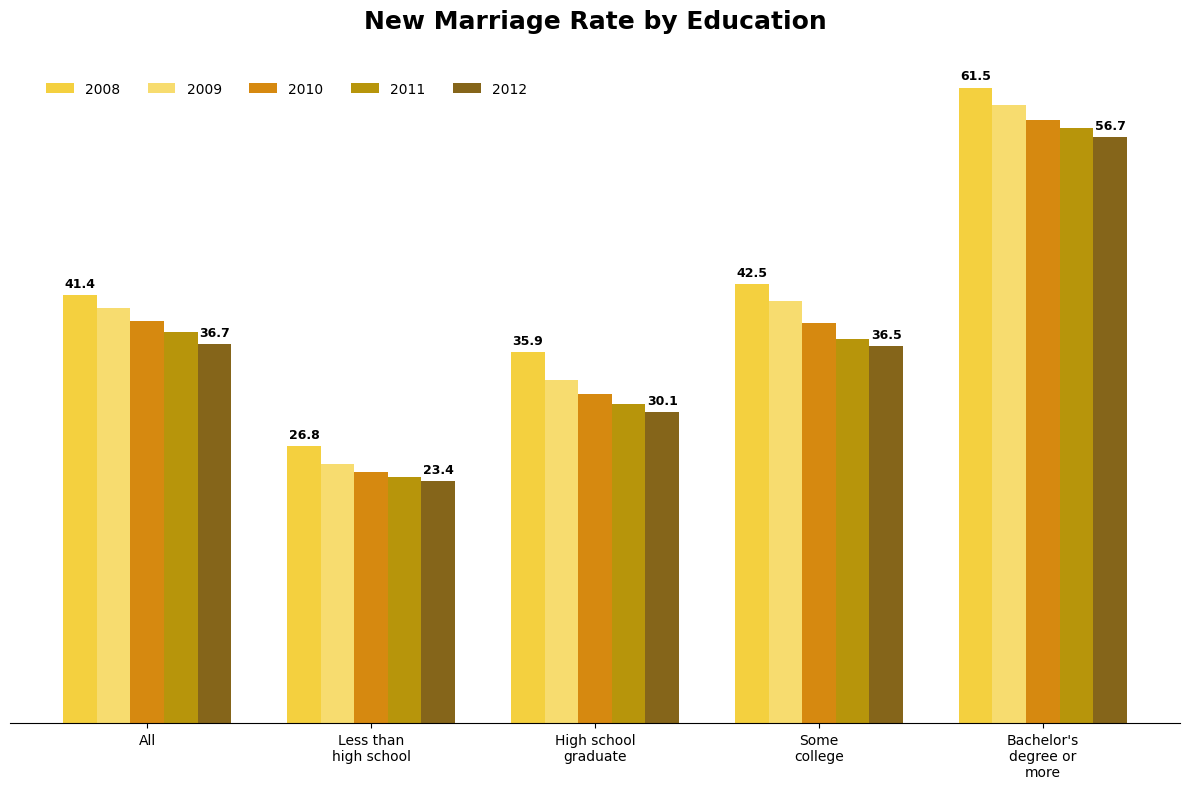

In [94]:
education_levels = ['All', 'Less than\nhigh school', 'High school\ngraduate', 'Some\ncollege', "Bachelor's\ndegree or\nmore"]
years = ['2008', '2009', '2010', '2011', '2012']

# Marriage rate data
marriage_data = {
    'All': [41.4, 40.2, 38.9, 37.8, 36.7],
    'Less than\nhigh school': [26.8, 25.1, 24.3, 23.8, 23.4],
    'High school\ngraduate': [35.9, 33.2, 31.8, 30.9, 30.1],
    'Some\ncollege': [42.5, 40.8, 38.7, 37.2, 36.5],
    "Bachelor's\ndegree or\nmore": [61.5, 59.8, 58.4, 57.6, 56.7]
}
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors
colors = ['#F4D03F', '#F7DC6F', '#D68910', '#B7950B', '#85651A']

# Create grouped bar chart
x = np.arange(len(education_levels))
width = 0.15

# Find highest and lowest values for each education level
education_min_max = {}
for edu in education_levels:
    values = marriage_data[edu]
    min_val = min(values)
    max_val = max(values)
    min_year_idx = values.index(min_val)
    max_year_idx = values.index(max_val)
    education_min_max[edu] = {
        'min_val': min_val, 'max_val': max_val,
        'min_year_idx': min_year_idx, 'max_year_idx': max_year_idx
    }

# Plot bars for each year
for i, year in enumerate(years):
    values = [marriage_data[edu][i] for edu in education_levels]
    bars = ax.bar(x + i * width, values, width, label=year, color=colors[i])
    
    # Add value labels only for highest and lowest bars in each education category
    for j, (bar, value) in enumerate(zip(bars, values)):
        edu = education_levels[j]
        # Only label if this is the min or max value for this education level
        if (i == education_min_max[edu]['min_year_idx'] or 
            i == education_min_max[edu]['max_year_idx']):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value}', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax.set_title('New Marriage Rate by Education', fontsize=18, fontweight='bold', pad=20)

# Set x-axis
ax.set_xticks(x + width * 2)
ax.set_xticklabels(education_levels, fontsize=10)

# Remove y-axis ticks
ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)

# Create legend
legend_elements = []
for i, year in enumerate(years):
    legend_elements.append(plt.Rectangle((0,0),1,1, fc=colors[i], label=year))

ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.02, 0.98), 
          ncol=5, frameon=False, fontsize=10)

plt.tight_layout()
plt.show()
